In [1]:
import os
import torch
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan, train_1d_scan_multi_gpu

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

In [2]:
data_dir = 'data'

In [3]:
# load data:
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))
print(f'train k shape: {train_dset.k.shape}')
print(f'test img shape: {train_dset.images.shape}')
print(f'train k shape: {test_dset.k.shape}')
print(f'test img shape: {test_dset.images.shape}')


# image bins: 
bins_x = torch.linspace(-0.01961639, 0.01961639, train_dset.images.shape[-2])
bins_y = torch.linspace(-0.01961639, 0.01961639, train_dset.images.shape[-1])

train k shape: torch.Size([7, 3, 1])
test img shape: torch.Size([7, 3, 200, 200])
train k shape: torch.Size([7, 3, 1])
test img shape: torch.Size([7, 3, 200, 200])


image size = 39 x 39 mm
test samples boxed in orange


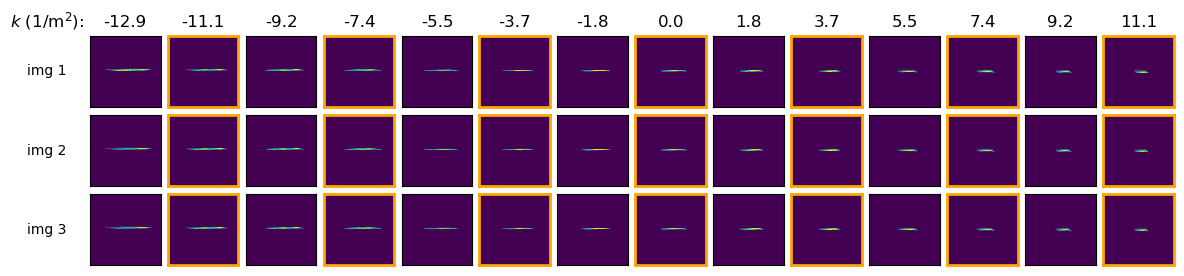

In [4]:
fig, ax = plot_scan_data(train_dset, test_dset, bins_x, bins_y)
plt.show()

In [5]:
# diagnostic beamline:
lattice = quad_drift(l_d=1.33 - (0.12/2), l_q=0.12)

# design momentum (eV)
p0c = 43e6

# diagnostic screen: 
bandwidth = (bins_x[1]-bins_x[0]) / 2
screen = ImageDiagnostic(bins_x, bins_y, bandwidth)

In [6]:
# training
pred_beam = train_1d_scan(
    train_dset, 
    lattice, 
    p0c, 
    screen, 
    n_epochs=1_000, 
    device='cuda',
    n_particles = 50_000
)

Using device: cuda


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4615179., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(626652.8125, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(708418.6875, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(426025.4688, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(402340.7188, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(433567.8125, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(383705.4375, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(377160.6562, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(454183.1875, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(380753.2188, device='cuda:0', grad_fn=<MulBackward0>)


In [7]:
# predicted screens:
ks = torch.vstack((train_dset.k, test_dset.k))
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 39 x 39 mm
test samples boxed in orange


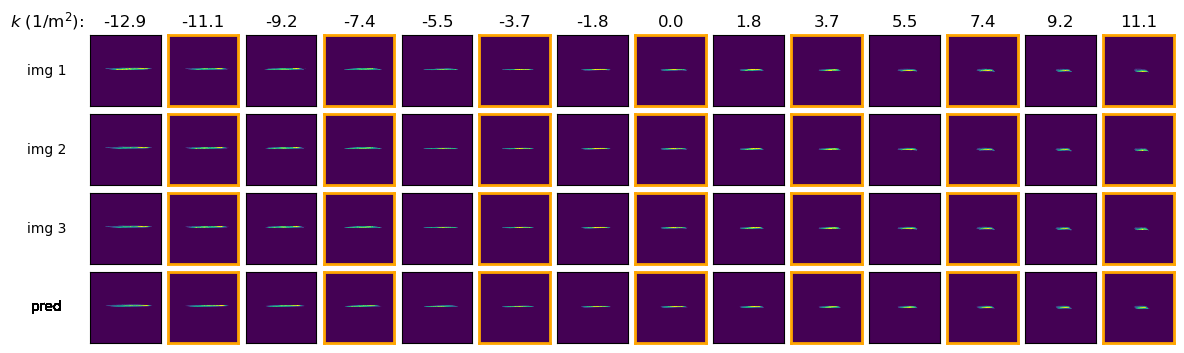

In [8]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins_x, bins_y)
plt.show()

data
k = tensor([-3.6947]) 1/m$^2$


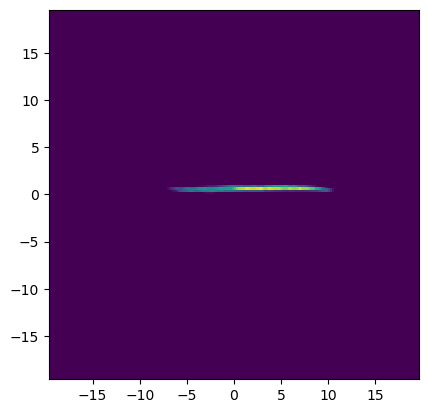

In [9]:
import numpy as np
i_k = 2
print('data')
print(f'k = {test_dset.k[i_k,0]} 1/m$^2$')
extent = np.array([bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]])*1e3
plt.imshow(test_dset.images[i_k,0,:,:].T, 
            origin = 'lower',
            extent = extent,
            interpolation = 'none')

plt.show()

pred
k = tensor([-5.5421]) 1/m$^2$


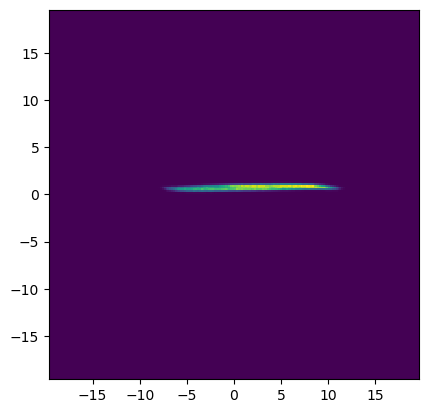

In [10]:
print('pred')
print(f'k = {pred_dset.k[i_k,0]} 1/m$^2$')
extent = np.array([bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]])*1e3
plt.imshow(pred_dset.images[i_k,0,:,:].T, 
            origin = 'lower',
            extent = extent,
            interpolation = 'none')
plt.show()

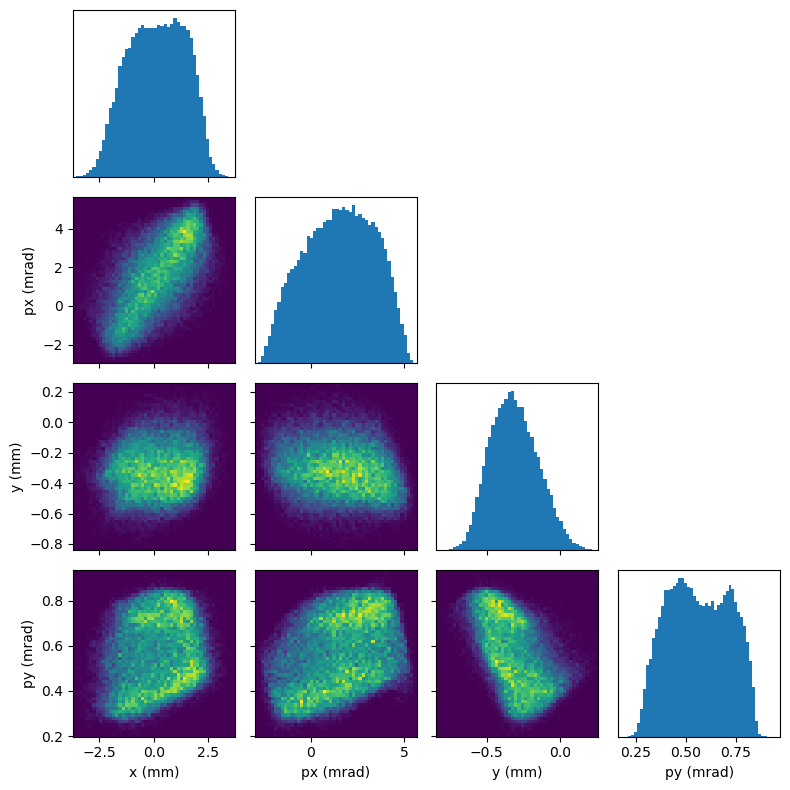

In [11]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=50,
                           background=False)
plt.show()

In [12]:
pred_beam_np = pred_beam.numpy_particles()

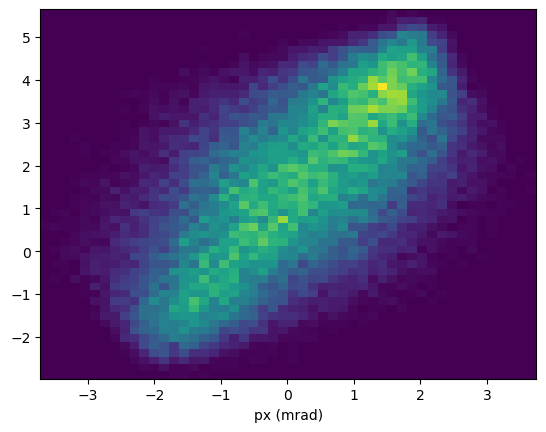

In [13]:
plt.hist2d(pred_beam_np.x*1e3, pred_beam_np.px*1e3, bins=50)
plt.xlabel('x (mm)')
plt.xlabel('px (mrad)')
plt.show()

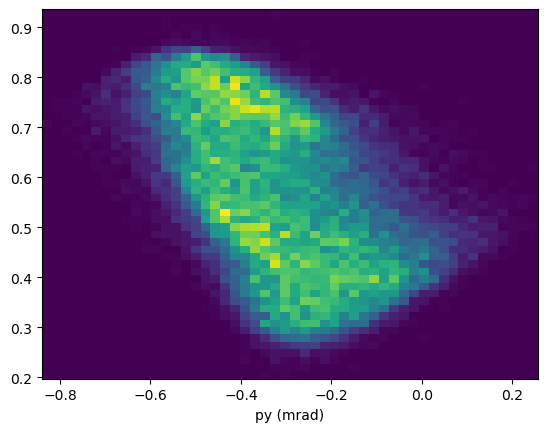

In [14]:
plt.hist2d(pred_beam_np.y*1e3, pred_beam_np.py*1e3, bins=50)
plt.xlabel('y (mm)')
plt.xlabel('py (mrad)')
plt.show()

In [15]:
from bmadx.constants import M_ELECTRON

def emittance(x, px, p0c):
    """"normalized emittance valid in ultrarelativistic limit."""
    cov = np.cov(x, px)
    det = np.linalg.det(cov)
    geom_em = np.sqrt(det)
    gamma = np.sqrt(1+(p0c/M_ELECTRON)**2)
    return gamma*geom_em

In [16]:
em_x = emittance(pred_beam_np.x, pred_beam_np.px, p0c)
em_y = emittance(pred_beam_np.y, pred_beam_np.py, p0c)
print(f'normalized x emittance: {em_x*1e6:.3f} mm-mrad')
print(f'normalized y emittance: {em_y*1e6:.3f} mm-mrad')

normalized x emittance: 152.939 mm-mrad
normalized y emittance: 1.733 mm-mrad


## Multi GPU training with increased number of particles

In [17]:
# clear CUDA memory cache
torch.cuda.empty_cache()

In [18]:
# training
pred_beam = train_1d_scan_multi_gpu(
    train_dset, 
    lattice, 
    p0c, 
    screen, 
    n_epochs=1_000, 
    device='cuda',
    n_particles = 500_000
)

Using device: cuda


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0 tensor([4872853.5000, 4872853.5000, 4872853.5000, 4872853.5000],
       device='cuda:0', grad_fn=<MulBackward0>)
100 tensor([496471.9062, 496471.9062, 496471.9062, 496471.9062], device='cuda:0',
       grad_fn=<MulBackward0>)
200 tensor([461466.5625, 461466.5625, 461466.5625, 461466.5625], device='cuda:0',
       grad_fn=<MulBackward0>)
300 tensor([490215., 490215., 490215., 490215.], device='cuda:0',
       grad_fn=<MulBackward0>)
400 tensor([389322.0312, 389322.0312, 389322.0312, 389322.0312], device='cuda:0',
       grad_fn=<MulBackward0>)
800 tensor([360905.7812, 360905.7812, 360905.7812, 360905.7812], device='cuda:0',
       grad_fn=<MulBackward0>)
900 tensor([364992.5312, 364992.5312, 364992.5312, 364992.5312], device='cuda:0',
       grad_fn=<MulBackward0>)


In [19]:
# predicted screens:
ks = torch.vstack((train_dset.k, test_dset.k))
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 39 x 39 mm
test samples boxed in orange


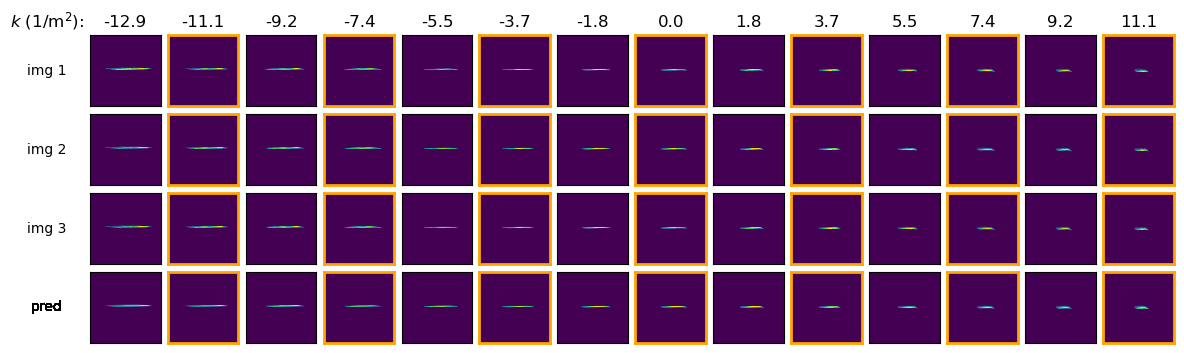

In [20]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins_x, bins_y)
plt.show()

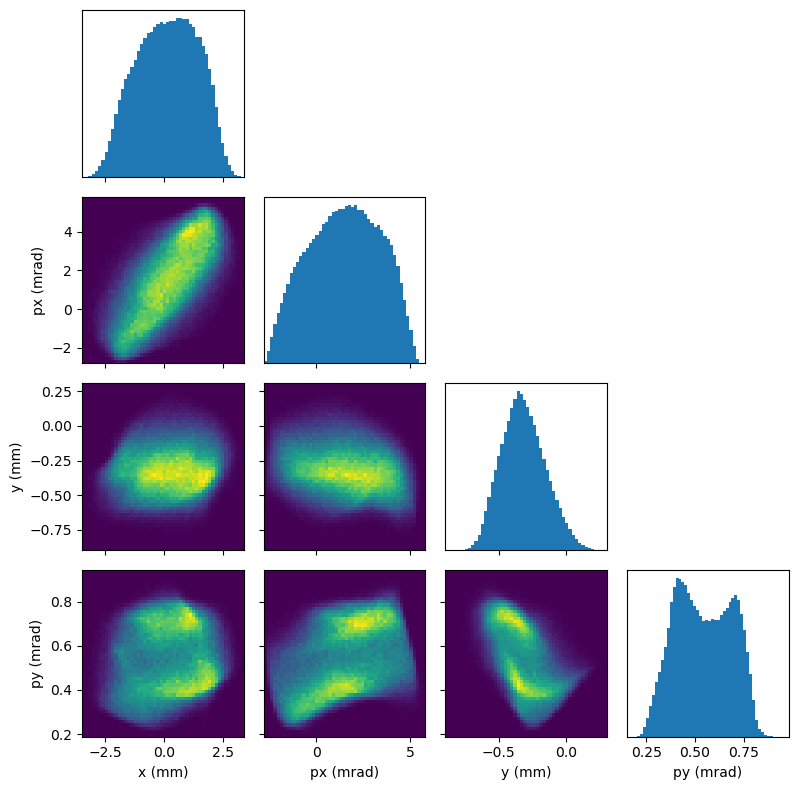

In [21]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=50,
                           background=False)
plt.show()